In [1]:
import numpy as np

In [45]:
## Doing this because of the CRRAutility warnings

import warnings
warnings.filterwarnings('ignore')

### Consumption with Independent Shocks

_Notebook by Sebastian Benthall_

In this notebook, we will use the generic Bellman stage tools to build and solve a household consumption model with independent shocks (called elsewhere in HARK `ConsIndShock`).

We have predefined some stage definitions in this module:

In [2]:
import cons_stages

In [3]:
def display_stage(stage):
    print(f"x: {stage.inputs}, k: {stage.shocks}, a: {stage.actions}, y: {stage.outputs}")

The consumption stage models the transition $a = m - c$ where $c$ is the choice of consumption. It has not shocks.

In [4]:
c_stage = cons_stages.consumption_stage

display_stage(c_stage)

x: ['m'], k: {}, a: ['c'], y: ['a']


The labor stage has no actions. In this stage, the agent experiences exogenous shocks and grows their resources.

In [5]:
l_stage = cons_stages.labor_stage

display_stage(l_stage)

x: ['b'], k: {'theta': <HARK.distribution.Lognormal object at 0x7f51155acf10>, 'psi': <HARK.distribution.Lognormal object at 0x7f51155acfa0>}, a: [], y: ['m']


We can repeat these stages again and again to simulate the household earning and consuming over time.

But there's one small problem: the output of the consumption stage is $m$ while the input of the labor stage is $b$.

We need to transform $m$ to $b$.

In [9]:
from HARK.stage import Stage, backwards_induction

### TWIST STAGE

def twist(mapper):
    return Stage(
        transition = lambda x, k, a : {mapper[xi] : x[xi] for xi in mapper}, 
        inputs = list(mapper.keys()), 
        actions = [],
        outputs = list(mapper.values())
    )
    
      
twist_stage = twist({'a' : 'b'})



In [43]:
epsilon = cons_stages.epsilon

x_space =  np.linspace(epsilon*2,8,50)

stages_data = [
    {
        'stage' : c_stage,
        'x_grid' : {'m' : x_space},
        'optimizer_args' :{
            'a0f' : lambda x: x['m'] - epsilon
        }
    },
    {
        'stage' : twist_stage,
        'x_grid' : {'a' : x_space},
        'optimizer_args' :{}
    },
    {
        'stage' : l_stage,
        'x_grid' : {
            'b' : x_space,
        },
        'shock_approx_params' : {
            'psi' : 7, 
            'theta' : 7, 
        },
    }
]

In [47]:
def growth_v_y_terminal(y):
    return 0

sols = backwards_induction(stages_data * 4, growth_v_y_terminal)

11: X: ['b'], K: ['theta', 'psi'], A: [], Y: ['m']
Grid size: 2450
Time to backwards induce v_x: 0:00:06.096781
10: X: ['a'], K: [], A: [], Y: ['b']
Grid size: 50.0
Time to backwards induce v_x: 0:00:00.217839
9: X: ['m'], K: [], A: ['c'], Y: ['a']
Grid size: 50.0
Time to backwards induce v_x: 0:00:02.473512
8: X: ['b'], K: ['theta', 'psi'], A: [], Y: ['m']
Grid size: 2450
Time to backwards induce v_x: 0:00:15.470068
7: X: ['a'], K: [], A: [], Y: ['b']
Grid size: 50.0
Time to backwards induce v_x: 0:00:00.215863
6: X: ['m'], K: [], A: ['c'], Y: ['a']
Grid size: 50.0
Time to backwards induce v_x: 0:00:04.177904
5: X: ['b'], K: ['theta', 'psi'], A: [], Y: ['m']
Grid size: 2450
Time to backwards induce v_x: 0:00:15.602854
4: X: ['a'], K: [], A: [], Y: ['b']
Grid size: 50.0
Time to backwards induce v_x: 0:00:00.228912
3: X: ['m'], K: [], A: ['c'], Y: ['a']
Grid size: 50.0
Time to backwards induce v_x: 0:00:03.809969
2: X: ['b'], K: ['theta', 'psi'], A: [], Y: ['m']
Grid size: 2450
Time to 

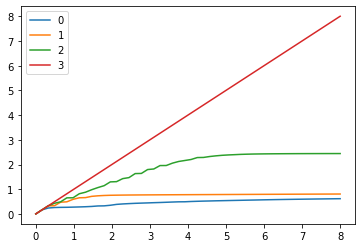

In [48]:
import matplotlib.pyplot as plt

for i, s in enumerate([sols[i] for i in (range(0,12, 3))]):
    plt.plot(x_space, [s.pi_star({'m' : m,}, {})['c'] for m in x_space], label = f"{i}")
    
plt.legend()